To ~start the process~ of making a classifier that distinguishes not only between pi0 and pipm, but also has a third class for heavily overlapping clusters. Steps:
1. get overlapping sample from rho data; load up the rho data and select only cases where the closest cluster to the pi0 is also the closest cluster to the pipm!! i.e. it will be one cluster only
2. do the data processing, concatenate the pi0, pipm, and overlapping rho data together (same amt of each!) & prep it for training the NN
3. set up and train the NN!
4. figure out a good way of visualizing the results

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d

import Week7_PFNutils as W

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

2021-08-09 07:00:21.272491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-09 07:00:33.098597: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-09 07:00:33.111825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-09 07:00:33.212637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-09 07:00:33.212676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-09 07:00:33.230681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
import vector as v

v.register_awkward()

In [3]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [4]:
events = ur.open(model_path+'rho_medium.root')

tree = events['EventTree']

In [5]:
branches = tree.arrays()

In [44]:
# I think I just wanna run through this manually so I know what I'm doing before I try running it straight out of 
#the scripts

def find_closest_rho(truthID_sel, trutheta_sel, truthphi_sel, truthpt_sel, truthmass_sel, clusE_sel, clusEta_sel, clusPhi_sel, clusPt_sel, clusmass_sel, SAME = False): #POI stands for particle of interest
    
    print('Finding cluster closest to particle', POI)
    #loop thru
    mindist_indices = []
    selec_inds = []
    for i in range(len(trutheta_sel)): 
        
        #select the poi:
        n_mask = truthID_sel[i] == 111
        #and the other particle:
        o_mask = np.logical_or(truthID_sel[i] == 211, truthID_sel[i] == -211)

        print(o_mask)
        #then get deltaR for poi
        partvec = ak.zip({
            "pt": truthpt_sel[i][n_mask],
            "eta": trutheta_sel[i][n_mask],
            "phi": truthphi_sel[i][n_mask],
            "mass": truthmass_sel[i][n_mask],
        })

        part4Dvec = ak.with_name(partvec, "Momentum4D")
        
        #and the other particle:
        partvec2 = ak.zip({
            "pt": truthpt_sel[i][o_mask],
            "eta": trutheta_sel[i][o_mask],
            "phi": truthphi_sel[i][o_mask],
            "mass": truthmass_sel[i][o_mask],
        })

        part4Dvec2 = ak.with_name(partvec2, "Momentum4D") 
        
        #and for the cluster
        deltaR = []
        deltaR2 = []
        for j in range(len(clusEta_sel[i])):
            clusvec = ak.zip({
                "pt": clusPt_sel[i][j],
                "eta": clusEta_sel[i][j],
                "phi": clusPhi_sel[i][j],
                "mass": clusmass_sel[i][j]})
            clus4Dvec = ak.with_name(clusvec, "Momentum4D")

            deltaR.append(part4Dvec.deltaR(clus4Dvec))
            deltaR2.append(part4Dvec2.deltaR(clus4Dvec))
            if deltaR == []:
                print('exception: empty deltaR') 
                print(part4Dvec, clus4Dvec, part4Dvec.deltaR(clus4Dvec), deltaR, i, j)
                
            ind = np.argmin(np.array(ak.flatten(deltaR)))
            ind2 = np.argmin(np.array(ak.flatten(deltaR2)))
            
        if (ind == ind2) == SAME: #only change lol; so if they are equal and you want to exclude those, then leave same as false, but if you do want the cluster to be the same just set same to true 
            selec_inds.append(i)
            mindist_indices.append(ind)
    
    print(len(mindist_indices))
    print('selec inds', len(selec_inds))
    #probably janky but use only the ones that were in mindist
    truthID_sel_cco = []
    trutheta_sel_cco = [] #also removes all the events/truth particles in the events with no clusters
    truthphi_sel_cco = []
    truthpt_sel_cco = []
    truthmass_sel_cco = []
    clusE_sel_cco = []
    clusEta_sel_cco =[]
    clusPhi_sel_cco = []
    clusPt_sel_cco = []
    clusmass_sel_cco = []
    mindist_inds_cco = []
    for i in selec_inds: 
        truthID_sel_cco.append(truthID_sel[i])
        trutheta_sel_cco.append(trutheta_sel[i])
        truthphi_sel_cco.append(truthphi_sel[i])
        truthpt_sel_cco.append(truthpt_sel[i])
        truthmass_sel_cco.append(truthmass_sel[i])
        clusE_sel_cco.append(clusE_sel[i])
        clusEta_sel_cco.append(clusEta_sel[i])
        clusPhi_sel_cco.append(clusPhi_sel[i])
        clusPt_sel_cco.append(clusPt_sel[i])
        clusmass_sel_cco.append(clusmass_sel[i])
        #mindist_inds_cco.append(mindist_indices[i])
    
    #remove the empty ones
    mindist_indices_full = []
    truthID_sel_full = []
    trutheta_sel_full = [] #also removes all the events/truth particles in the events with no clusters
    truthphi_sel_full = []
    truthpt_sel_full = []
    truthmass_sel_full = []
    clusE_sel_full = []
    clusEta_sel_full =[]
    clusPhi_sel_full = []
    clusPt_sel_full = []
    clusmass_sel_full = []
    
    full_inds = []
    for i in range(len(clusEta_sel_cco)): 
        if len(clusEta_sel_cco[i]) != 0: 
            mindist_indices_full.append(mindist_indices[i])
            truthID_sel_full.append(truthID_sel_cco[i])
            trutheta_sel_full.append(trutheta_sel_cco[i])
            truthphi_sel_full.append(truthphi_sel_cco[i])
            truthpt_sel_full.append(truthpt_sel_cco[i])
            truthmass_sel_full.append(truthmass_sel_cco[i])
            clusE_sel_full.append(clusE_sel_cco[i])
            clusEta_sel_full.append(clusEta_sel_cco[i])
            clusPhi_sel_full.append(clusPhi_sel_cco[i])
            clusPt_sel_full.append(clusPt_sel_cco[i])
            clusmass_sel_full.append(clusmass_sel_cco[i])
            full_inds.append(selec_inds[i])
      
   # print(len(mindist_indices_full), mindist_indices_full)
    clusEta_closest = []
    clusE_closest = [] #select only the closest clusters
    clusPhi_closest = []
    clusPt_closest = []
    clusmass_closest = []
    for i in range(len(clusEta_sel_full)):
        clusEta_closest.append(clusEta_sel_full[i][mindist_indices_full[i]])
        clusE_closest.append(clusE_sel_full[i][mindist_indices_full[i]])
        clusPhi_closest.append(clusPhi_sel_full[i][mindist_indices_full[i]])
        clusPt_closest.append(clusPt_sel_full[i][mindist_indices_full[i]])
        clusmass_closest.append(clusmass_sel_full[i][mindist_indices_full[i]])
       
    print('Closest clusters found.')
    return (truthID_sel_full, trutheta_sel_full, truthphi_sel_full, truthpt_sel_full, truthmass_sel_full, ak.Array(clusE_closest), ak.Array(clusEta_closest), ak.Array(clusPhi_closest), ak.Array(clusPt_closest), ak.Array(clusmass_closest), full_inds, mindist_indices_full)


In [6]:
truthE = branches.cluster_hitsTruthE
truthEIndex = branches.cluster_hitsTruthIndex
truthID = branches.truthPartPdgId
trutheta = branches.truthPartEta
truthphi = branches.truthPartPhi
truthpt = branches.truthPartPt
truthmass = branches.truthPartMass
clusE = branches.cluster_E
clusEta = branches.cluster_Eta
clusPhi = branches.cluster_Phi
clusPt = branches.cluster_Pt
clusmass = []
for i in range(len(clusE)): #define cluster mass to be zero :)
    clusmass.append(np.zeros(len(clusE[i])))

In [12]:
ID_aspd = ak.to_pandas(ak.flatten(truthID))

Text(2.2, 400000, ' 211 = $\\pi^+$ \n -211 = $\\pi^-$ \n 22 = $\\gamma$ \n 111 = $\\pi^0$ \n 213 = $\\rho^+$ \n -213 = $\\rho^-$ \n 11 = $e^-$ \n -11 = $e^+$')

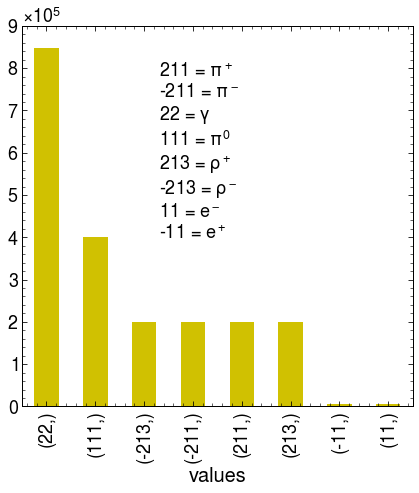

In [19]:
#examine first what the rhos are made up of
plt.figure(figsize=[7,7])
ID_aspd.value_counts().plot(kind='bar', color='xkcd:ugly yellow')
plt.text(2.2,400000, ' 211 = $\pi^+$ \n -211 = $\pi^-$ \n 22 = $\gamma$ \n 111 = $\pi^0$ \n 213 = $\\rho^+$ \n -213 = $\\rho^-$ \n 11 = $e^-$ \n -11 = $e^+$')

In [7]:
# I think easest way to do this is to just have a separate mask for each case - pi- and pi+?
def makemask(truthID, POI):#, partID2):
    #have to specify 4 particles: the delta of interest, what to avoid, the particle of interest that will later
    #be used, and then the other one 
    
    selectedinds = []    

    for i in range(len(truthID)): #basically: delta+, two categories: pip & n (without any ps) vs pi0 & p (no ns)
        if (POI in truthID[i]):# | (partID2 in truthID[i]):
            selectedinds.append(i)

    flag = np.zeros(len(truthID))
    flag[selectedinds] = 2
    
    mask = flag == 2
    
    return mask

In [8]:
mask211 = makemask(truthID, 211)
maskn211 = makemask(truthID, -211)

In [45]:
find_closest2(truthID[:1000], trutheta[:1000], truthphi[:1000], truthpt[:1000], truthmass[:1000], clusE[:1000], clusEta[:1000], clusPhi[:1000], clusPt[:1000], clusmass[:1000], 111, SAME = True)

Finding cluster closest to particle 111
[False, False, False, False, False]


ValueError: attempt to get argmin of an empty sequence

In [ ]:
#can I just run it on the delta convert sets??? I think it'll work
import convert_sets_splitdelta as cs

In [13]:
#cs.doit_cc(mask211, data_path+'rho_211.npz', 111, 211) #jesus this takes a long time lol

Working on /fast_scratch/atlas_images/v01-45/rho_medium.root
Loading data
Finding cluster closest to particle 111
103047
selec inds 103047
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/rho_211.npz


In [15]:
#cs.doit_cc(maskn211, data_path+'rho_n211.npz', 111, -211)

Working on /fast_scratch/atlas_images/v01-45/rho_medium.root
Loading data
Finding cluster closest to particle 111
102974
selec inds 102974
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/rho_n211.npz


In [16]:
#dang I forgot to add in the y... maybe I can do that later